In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm_notebook
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances


x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

# del X_train,X_test

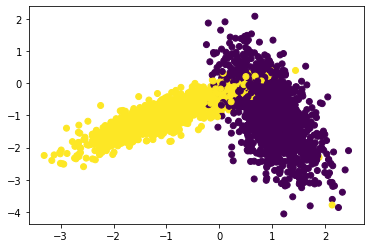

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
colors = {0:'red', 1:'blue'}
plt.scatter(X_test[:,0], X_test[:,1],c=y_test)
plt.show()

# Implementing Custom RandomSearchCV

<pre>
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    # x_train: its numpy array of shape, (n,d)
    # y_train: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # folds: an integer, represents number of folds we need to devide the data and test our model
    
    
    #1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    #2.devide numbers ranging from  0 to len(X_train) into groups= folds
    # ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
      group 1: 0-33, group 2:34-66, group 3: 67-100
    #3.for each hyperparameter that we generated in step 1:
        # and using the above groups we have created in step 2 you will do cross-validation as follows
        
        # first we will keep group 1+group 2 i.e. 0-66 as train data and group 3: 67-100 as test data, and find train and
          test accuracies
          
        # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and group 2: 34-66 as test data, and find
          train and test accuracies
          
        # third we will keep group 2+group 3 i.e. 34-100 as train data and group 1: 0-33 as test data, and find train and
          test accuracies
        # based on the 'folds' value we will do the same procedure
        
        # find the mean of train accuracies of above 3 steps and store in a list "train_scores"
        # find the mean of test accuracies of above 3 steps and store in a list "test_scores"
    #4. return both "train_scores" and "test_scores"

#5. call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and store the returned values into "train_score", and "cv_scores"
#6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
#7. plot the decision boundaries for the model initialized with the best hyperparameter, as shown in the last cell of reference notebook

</pre>

In [ ]:
from scipy.stats import randint 
import random

In [ ]:
#1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
def n_neighbors(param_range):
  descreteUniformRandomVariables_inRange = list(set(randint.rvs(param_range[0],param_range[1],size=100)))
  # odd values for majority use
  Odd_Numbers                            = [each for each in descreteUniformRandomVariables_inRange if each%2!=0 or each==1] 
  # 10 values randomly 
  randomTenValues                        = sorted(random.sample(Odd_Numbers,k=10))                                            
  return randomTenValues

In [ ]:
testing = n_neighbors((1,50))
print(testing)

[9, 17, 21, 23, 27, 29, 39, 41, 45, 47]


**The general procedure is as follows:**
1. Shuffle the dataset randomly.
2. Split the train dataset into k groups
3. For each unique group:
    1. Take a group as a hold out or cross validation data set
    2. Take the remaining groups as a training data set
    3. Fit a model on the training set and evaluate it on the cv data set
    4. Retain the evaluation score and discard the model
4. Summarize the skill of the model using the sample of model evaluation scores

reference: https://machinelearningmastery.com/k-fold-cross-validation/

In [ ]:
from sklearn.utils import shuffle

# splitting indexes into k-fold:
# reference: https://stackoverflow.com/questions/2130016/splitting-a-list-into-n-parts-of-approximately-equal-length
#2.devide numbers ranging from  0 to len(X_train) into groups= folds
# ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
# group 1: 0-33, group 2:34-66, group 3: 67-100
# function returns list of lists contains k parts (as k-fold) of equal no of indexes, which are used to split train data into k-parts for k-fold cv test.
def chunkIt(seq,k):
  avg = len(seq)/float(k)
  out = []
  last = 0.0
  while last < len(seq):
    out.append(seq[int(last):int(last + avg)])
    last += avg
  return out
  

In [ ]:
testing = chunkIt(range(12), 3)
print(testing)

[range(0, 4), range(4, 8), range(8, 12)]


In [ ]:
from sklearn.metrics import accuracy_score
def randomSearchCV(x_train,y_train,classifier,n_neighbor,kfolds):
    n_neighbor = n_neighbor
    indexes = list(range(len(x_train)))
    # split train indices into k-chunks for train and cv in future use.
    splits = chunkIt(indexes,kfolds)            
    # list to store cross validation mean scores,train mean scores for perticular k-Nearest Neighbor from k-fold cross validation.
    cvscores = []                               
    trainscores= []                             

    for each_neighbor in tqdm_notebook(n_neighbor):      # for each neighbor calculate trainfold and cvfold 
        trainfold = []
        cvfold  = []
        
        # k-fold cv for each neighbor
        for i in range(len(splits)):           
            train_indexes = []

            cv_indexes = splits[i]            # take one split data out for cross validation using their indices.
            for j in range(len(splits)):      # assign remaining split data into train data using their indices.
                if j!=i:
                    train_indexes.extend(splits[j])  

            X_train = x_train[train_indexes]        # k-1 parts into train data
            Y_train = y_train[train_indexes]
            X_cv  = x_train[cv_indexes]             # 1 part into cv data.
            Y_cv  = y_train[cv_indexes]

            classifier.n_neighbors = each_neighbor      # classifier initialization
            classifier.fit(X_train,Y_train)             # fit on train data

            Y_predicted = classifier.predict(X_cv)                      # predict on cross-validation data
            cvfold.append(accuracy_score(Y_cv,Y_predicted))             # store in cv fold
            
            Y_predicted = classifier.predict(X_train)                   # predict on train data
            trainfold.append(accuracy_score(Y_train,Y_predicted))       # store in train fold

        # storing mean score for cv and train data related to perticular k-nn.
        cvscores.append(np.mean(np.array(cvfold)))                  
        trainscores.append(np.mean(np.array(trainfold)))              

    return trainscores,cvscores
            


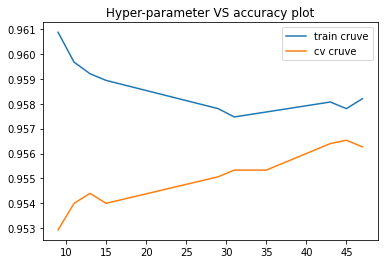

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")

neigh = KNeighborsClassifier()        # k-nn classifier initialize
nRange = (1,50)                       # range for randamCV
folds = 3                             # k-fold value
# generating k random hyperparameter values using function n_neighbors
params = n_neighbors(nRange)      

trainscores,cvscores = randomSearchCV(X_train, y_train, neigh,params, folds)

plt.plot(params,trainscores, label='train cruve')
plt.plot(params,cvscores, label='cv cruve')
plt.title('Hyper-parameter VS accuracy plot')
plt.legend()
plt.show()
    

In [ ]:
print(params)

[9, 11, 13, 15, 29, 31, 35, 43, 45, 47]


In [ ]:
# function to pick best k by using min diff b/n errors.
def bestK(trainscores,testscores,params):
  index = 0
  min   = 10
  for i in range(len(cvscores)):
    x = 1 - trainscores[i]        # error = (1 - accuracy) for trainscores for perticular k
    y = 1- cvscores[i]            # error for cv scores
    diff = abs(x-y)               # absolute diff b/w train_error and cv_error
    if (diff < min):
      min = diff
      index = i                   # picking min diff error k - hyperparameter.
  return params[index]



In [ ]:
bestk= bestK(trainscores,cvscores,params)
print(bestk)

45


In [ ]:
# understanding this code line by line is not that importent 
def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

Best k-  45


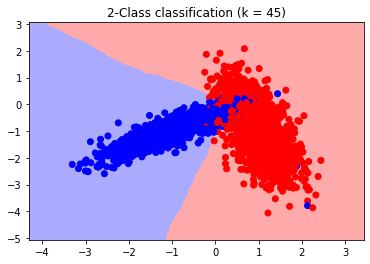

In [ ]:
# from above best k's "bestk"
print("Best k- ",bestk)
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = bestk)
neigh.fit(X_train, y_train)
# decison_boundary on actual test data by using best choosen 'k-hyperparameter'
plot_decision_boundary(X_test[:, 0], X_test[:, 1], y_test, neigh)  